# Приложение №2. Визуализация и анализ результатов обработки данных
## Аномалии осадков на ВЕР с 1940 по 2014

## Загрузка данных

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

import seaborn as sns

import numpy as np
import pandas as pd
import xarray as xr

import os
import math as m

In [4]:
from IPython.display import display,HTML
display(HTML('<style>.container {width: 80% !important}</style>'))

In [5]:
directory = "E:/Climate/downloads/historical/"

file_list = np.array ([file for file in os.listdir(directory) if file.endswith('.nc')])

In [33]:
# !conda install -c conda-forge netcdf4 h5netcdf -y

In [7]:
# Aggregating files by dictionaries:
# timcor (2d spatial data), fldcor (array of values by timesteps), timmean (single value)
# tr_A and tr_B contain parameters of linear trends of anomalies time series (average values for shift and slope)
file_dict = {}
timcor = {}
fldcor = {}
timmean = {}
fldmeans = {}
tr_A = {}
tr_B = {}
for file in file_list:
    dataset = xr.open_dataset(os.path.join(directory, file), decode_times=False)
    file_dict[file] = dataset
    if 'timcor' in file:
        timcor[file] = dataset
    if 'fldcor' in file and not 'timmean' in file:
        fldcor[file] = dataset
    if 'timmean' in file:
        timmean[file] = dataset
    if 'fldmean_trend1' in file:
        if 'ERA' in file:
            tr_A[file.split('trend1_')[1]] = dataset*1000
        else:
            tr_A[file.split('trend1_')[1]] = dataset*86400
    if 'fldmean_trend2' in file:
        if 'ERA' in file:
            tr_B[file.split('trend2_')[1]] = dataset*1000
        else:
            tr_B[file.split('trend2_')[1]] = dataset*86400
    if 'fldmean_' in file and not 'trend' in file and not 'ERA' in file:
        fldmeans[file] = dataset*86400

C:\Users\nslob\anaconda3\Lib\site-packages\xarray\conventions.py:431: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [8]:
file='fldmean_pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-201412_regular_year_axis_anom_box_ymean.nc'
print(file)
file_dict[file].pr.values

fldmean_pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-201412_regular_year_axis_anom_box_ymean.nc


array([[[ 6.04181574e-07]],

       [[ 8.09012181e-07]],

       [[ 1.33164343e-06]],

       [[ 8.43009300e-07]],

       [[ 2.24094453e-06]],

       [[ 1.30786119e-06]],

       [[-1.86717487e-06]],

       [[ 9.71594018e-07]],

       [[ 1.05214892e-06]],

       [[-7.29866476e-07]],

       [[-2.64187566e-07]],

       [[-2.61883754e-07]],

       [[ 6.90458631e-07]],

       [[-1.22757828e-06]],

       [[ 1.84785274e-06]],

       [[ 9.59884805e-07]],

       [[-2.43953837e-07]],

       [[ 5.75883433e-07]],

       [[ 6.30614620e-07]],

       [[ 9.38301543e-07]],

       [[ 3.34951856e-07]],

       [[ 5.79878914e-07]],

       [[-1.16020502e-06]],

       [[-4.75295278e-07]],

       [[-1.32876154e-07]],

       [[-1.98111849e-06]],

       [[ 1.94770142e-06]],

       [[-3.33454163e-07]],

       [[-1.08134245e-06]],

       [[ 9.04959431e-07]],

       [[-4.74900023e-07]],

       [[ 8.56244342e-07]],

       [[-5.79233088e-08]],

       [[-1.88830682e-07]],

       [[ 4.36

## Функции для отображения наборов данных в виде карт и временных рядов

In [10]:
def data_disp (keyword, stopword, data_dict, columns, n_lat, n_lon, pos_in_filename, title,
               scale_min, scale_max, fig_name):

    #### Displayig 25 timcors --- this will work only for 2d arrays with 1 timestep
    if keyword == '' and stopword == '':
        data_list = np.array([file for file in data_dict.keys()])
    elif stopword == '':
        data_list = np.array([file for file in data_dict.keys() if keyword in file])
    else:
        data_list = np.array([file for file in data_dict.keys() if (keyword in file and not stopword in file)])

    data_list = np.sort(data_list)
    n_subs = m.ceil(len(data_list)/columns)*columns
    fig, ax = plt.subplots(n_subs//columns, columns, figsize=(4*columns, 1.5+2*(n_subs//columns)), layout='constrained')
    fig.suptitle (title, fontsize=18)

    for i in range(len(data_list)):
        row = i // columns
        column = i % columns

        variable = list(data_dict[data_list[i]].variables)[-1]
        array = data_dict[data_list[i]][variable][0]
        name = data_list[i].split('_')[pos_in_filename]

        plotted = ax[row, column].imshow(array[::-1], cmap='RdYlBu_r', vmin=scale_min, vmax=scale_max) # best scale for timcor t7:
        ax[row, column].set_title(name, fontsize=14)

        if n_lat*n_lon != 0:
            # Counting how to place ticks
            longitudes = np.array (array['lon'], dtype='int')
            latitudes = np.array (array['lat'][0:180]+0.5, dtype='int')
            lon_step = len(longitudes)//(n_lon-1)
            lat_step = m.ceil(len(latitudes)/(n_lat))

            ax[row, column].tick_params(length=2, labelsize=10)
            ax[row, column].set_xticks(np.arange(0, len(longitudes), lon_step))
            ax[row, column].set_xticklabels(list(str(lon) + 'E' for lon in longitudes[::lon_step]))
            ax[row, column].set_yticks(np.arange(0, len(latitudes), lat_step))
            ax[row, column].set_yticklabels(list(str(lat) + 'N' for lat in latitudes[-1::-lat_step]))
            ax[row, column].grid(color='black', linestyle='dashed', linewidth=0.5, alpha=0.2)
    for i in range(n_subs):
        row = i // columns
        column = i % columns
        if i >= len(data_list):
            fig.delaxes(ax[row][column])

    cbar = fig.colorbar(plotted, ax=ax, location='bottom', anchor=(0.5, 0.5), shrink=0.4, extend='both', orientation='horizontal', aspect=40)
    plt.show()

    if (fig_name != '' and not '.' in fig_name):    fig.savefig('precipitation_fig/'+fig_name+'.png', dpi=300)
    if (fig_name != '' and fig_name.endswith('.eep')):    fig.savefig('precipitation_fig/'+fig_name)

In [11]:
def data_plot (keyword, stopword, data_dict, columns, pos_in_filename, title, fig_name, step):

    #### Displayig 25 fldcor --- as 25 plots with y = value and x = time

    # making a list of files for display
    if keyword == '' and stopword == '':
        data_list = np.array([file for file in data_dict.keys()])
    elif stopword == '':
        data_list = np.array([file for file in data_dict.keys() if keyword in file])
    else:
        data_list = np.array([file for file in data_dict.keys() if (keyword in file and not stopword in file)])
    data_list = np.sort(data_list)
    n_subs = m.ceil(len(data_list)/columns)*columns

    fig, ax = plt.subplots(n_subs//columns, columns, figsize=(4*columns, 1.5+2*(n_subs//columns)), layout='constrained')

    fig.suptitle (title, fontsize=14)

    array = data_dict[data_list[0]]
    df = array.to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
    roll = df.rolling(step).mean()
    row = 0 // columns
    column = 0 % columns

    for i in range(len(data_list)):
        row = i // columns
        column = i % columns

        variable = list(data_dict[data_list[i]].variables)[-1]
        name = data_list[i].split('_')[pos_in_filename]
        array = data_dict[data_list[i]]
        df = array.to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
        df = df[df['bnds'] == 1]

        ax[row, column].plot(np.arange(1940, 2015), df[variable], alpha=0.6)

        ax[row, column].set_ylim(-1, 1)
        ax[row, column].set_title(name, fontsize=10)
        ax[row, column].tick_params(length=2, labelsize=10)
        ax[row, column].text(1940, 0.8, round(float(timmean['timmean_'+data_list[i]][variable].values), 3))

        if step > 1:
            df = array.to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
            df = df[df['bnds'] == 1]

            roll = df.rolling(step).mean()
            ax[row, column].plot(np.arange(1940, 2015), roll[variable], linestyle='-', color='red')

    for i in range(n_subs):
        row = i // columns
        column = i % columns
        if i >= len(data_list):
            fig.delaxes(ax[row][column])

        ax[row, column].grid(color='black', linestyle='dotted', linewidth=0.5, alpha=0.4)
    plt.show()
    if (fig_name != '' and not '.' in fig_name):    fig.savefig('precipitation_fig/'+fig_name+'.png', dpi=300)
    if (fig_name != '' and fig_name.endswith('.eep')):    fig.savefig('precipitation_fig/'+fig_name)

## Визуализация

Opened: pr_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc


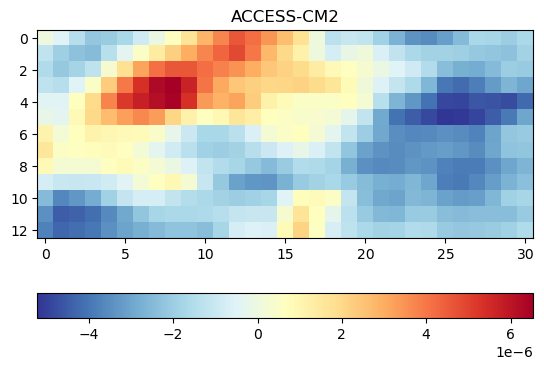

In [13]:
# How to plot one file

# file = 'timcor_pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc'
file = file_list[50]
# print(file_dict[file_list[0]])
variable = str(list(file_dict[file].variables)[-1])
plt.imshow(file_dict[file][variable][0][::-1], cmap='RdYlBu_r')

plt.title(file.split('_')[2], fontsize=12)
plt.colorbar(orientation='horizontal')
print(f"Opened: {file}")
plt.show()

In [14]:
# Open timcors from my directory
i = 0
for file in file_dict.keys():
    if ('timcor' in file and not '__' in file):
        print (file)
        i+=1
print(f"Total: {i}")

timcor_pr_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
timcor_pr_Amon_ACCESS-ESM1-5_historical_r11i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
timcor_pr_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_194001-201412_regular_year_axis_anom_box_ymean.nc
timcor_pr_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
timcor_pr_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
timcor_pr_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
timcor_pr_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
timcor_pr_Amon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
timcor_pr_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_185001-201412_regular_year_axis_anom_box_ymean.nc
timcor_pr_Amon_CNRM-CM6-1_historical_r1i1p1f2_gr_185001-201412_regular_year_axis_anom_box_ymean.nc
tim

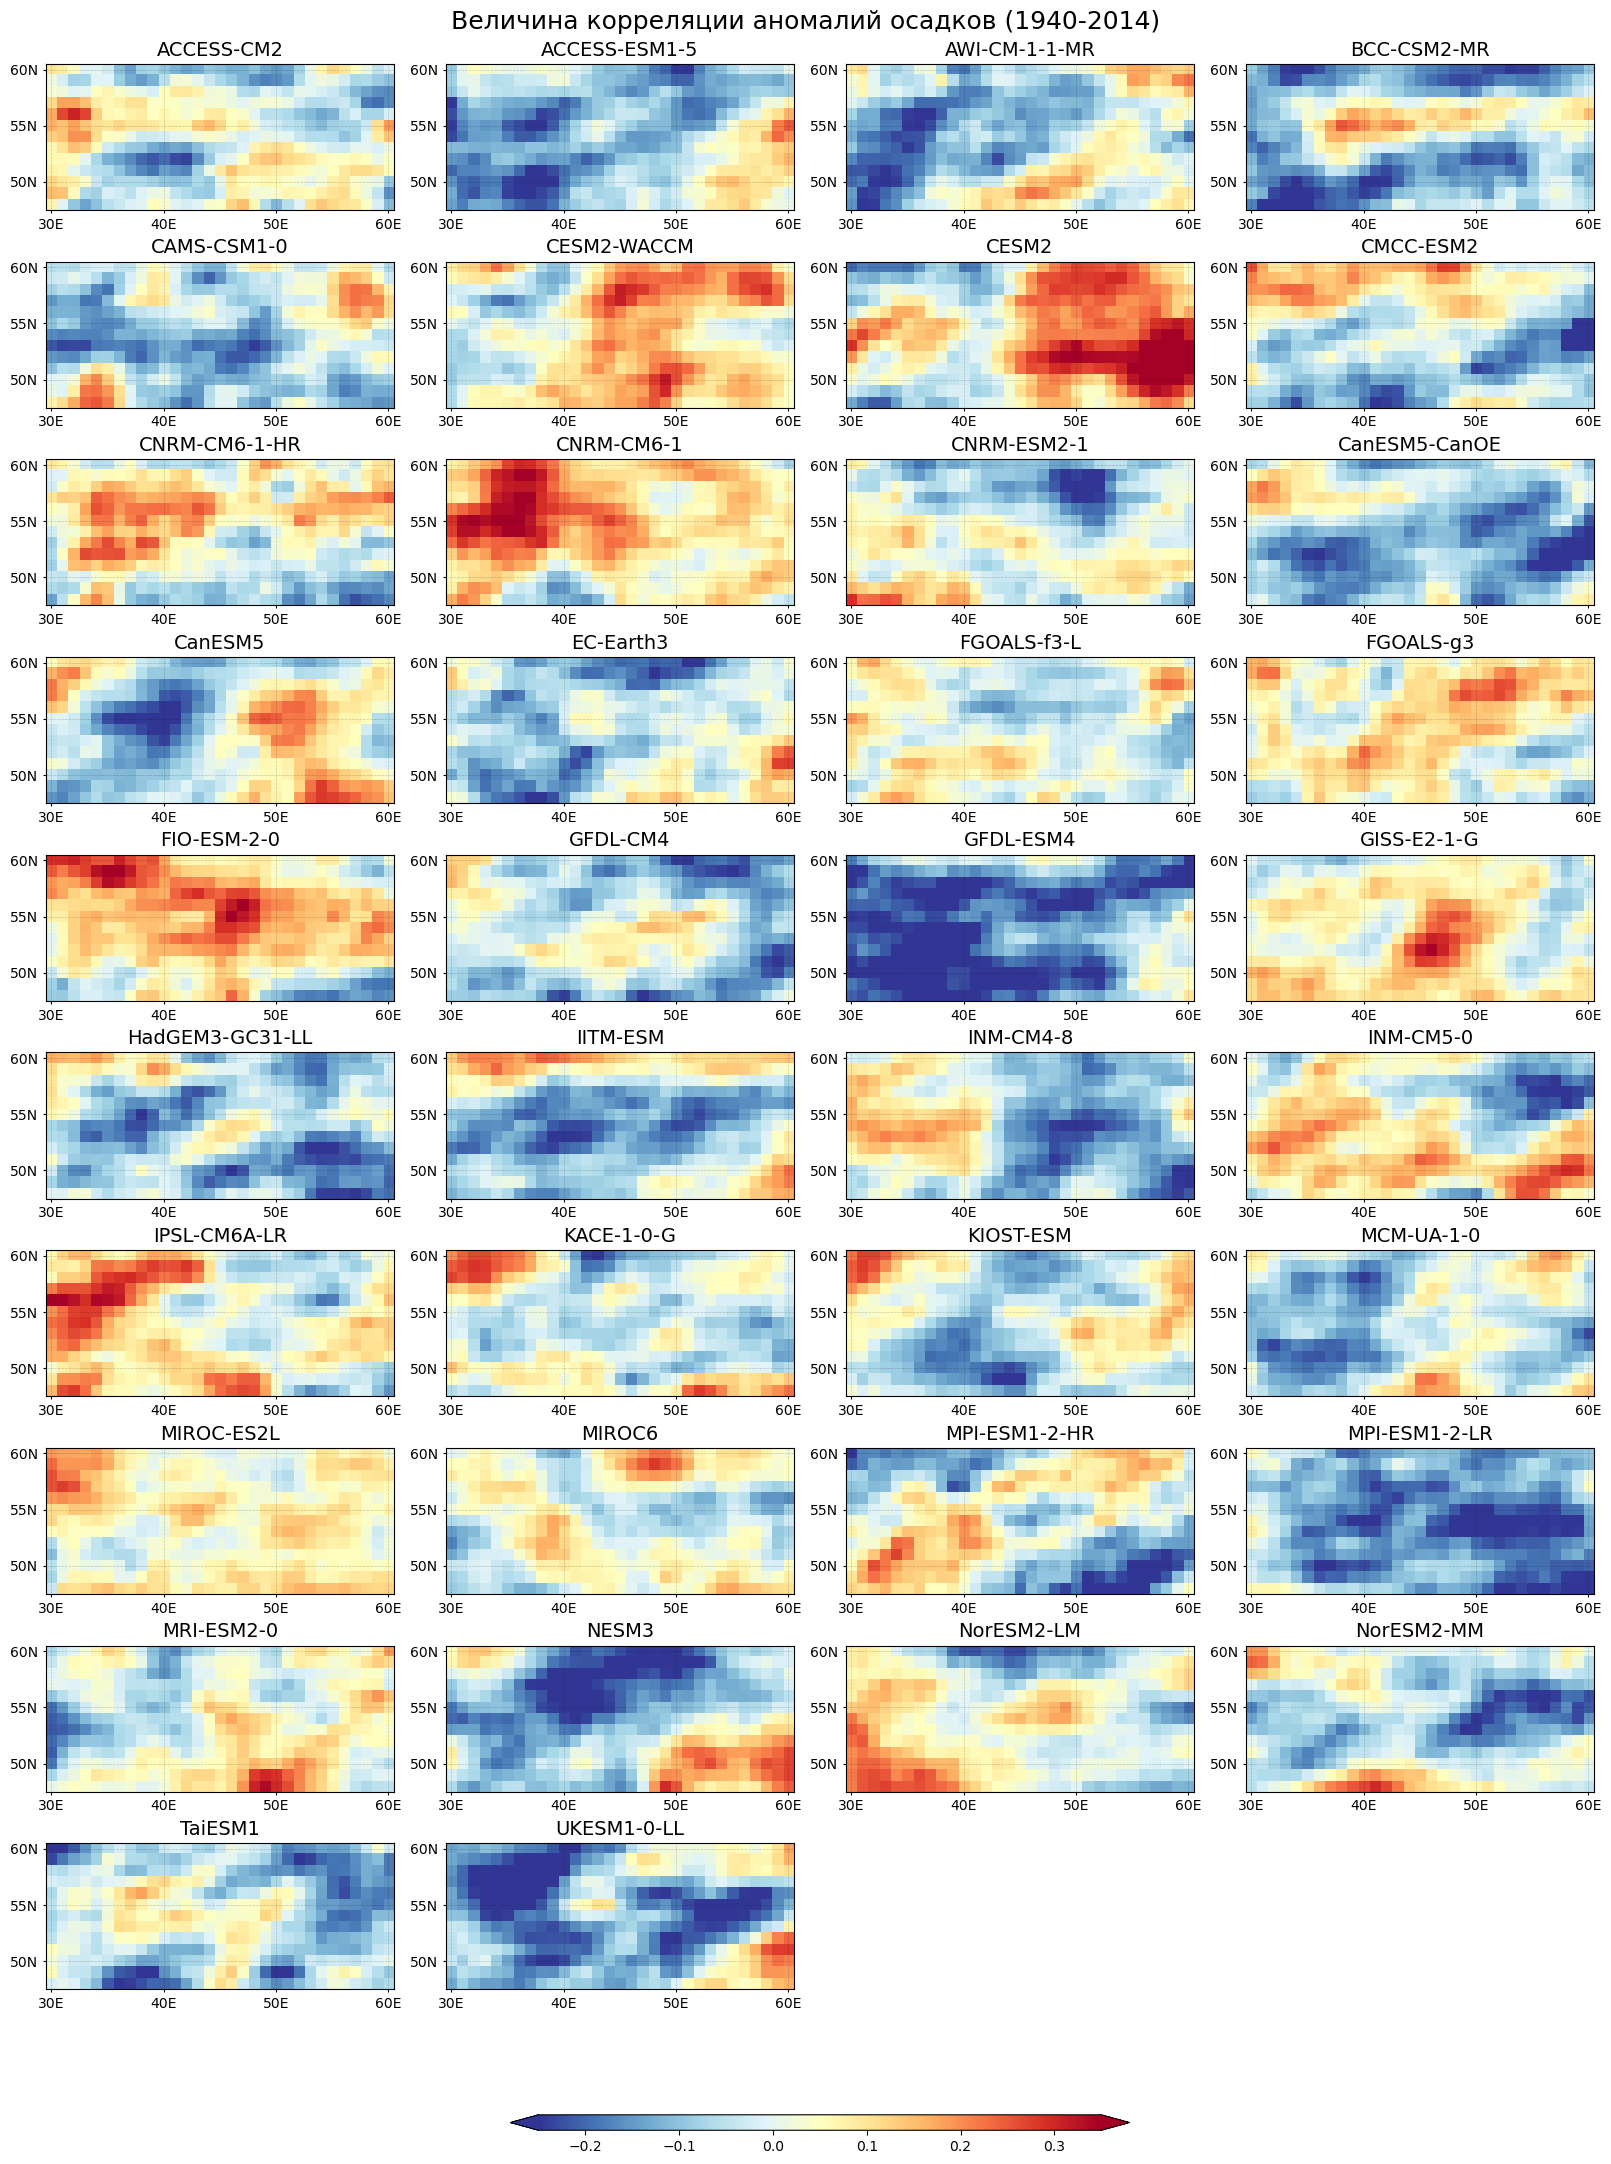

In [15]:
# data_disp (keyword, stopword, data_dict, columns, n_lat, n_lon, pos_in_filename, title, scale_min, scale_max, fig_name):
data_disp ('', '', timcor, 4, 3, 4, 3, "Величина корреляции аномалий осадков (1940-2014)", -0.25, 0.35, '')

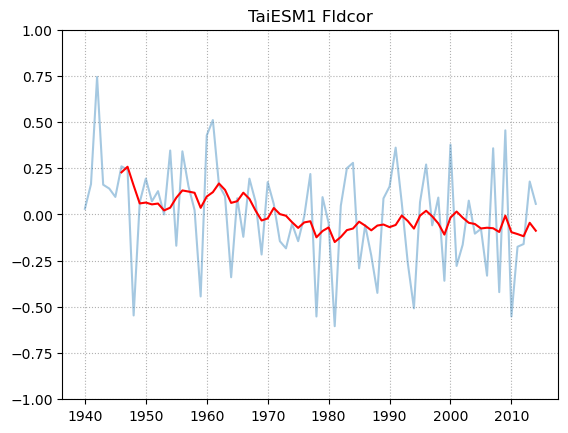

In [16]:
# Plotting fldcor

file = 'fldcor_pr_Amon_TaiESM1_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc'
df = fldcor[file].to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
step = 7
df = df[df['bnds'] == 1]

plt.plot(np.arange(1940, 2015,1), df['pr'], alpha=0.4)

roll = df.rolling(step).mean()
plt.plot(np.arange(1940, 2015,1), roll['pr'], linestyle='-', color='red')

plt.title(file.split('_')[3] + " Fldcor")
plt.grid(linestyle=':')
plt.ylim(-1,1)
plt.show()

In [17]:
# Open fldcors from my directory
i = 0
for file in file_dict.keys():
    if ('fldcor' in file and not 'timmean' in file):
        print (file)
        i+=1
print(f"Total: {i}")

fldcor_pr_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
fldcor_pr_Amon_ACCESS-ESM1-5_historical_r11i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
fldcor_pr_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_194001-201412_regular_year_axis_anom_box_ymean.nc
fldcor_pr_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
fldcor_pr_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
fldcor_pr_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
fldcor_pr_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
fldcor_pr_Amon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412_regular_year_axis_anom_box_ymean.nc
fldcor_pr_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_185001-201412_regular_year_axis_anom_box_ymean.nc
fldcor_pr_Amon_CNRM-CM6-1_historical_r1i1p1f2_gr_185001-201412_regular_year_axis_anom_box_ymean.nc
fld

C:\Users\nslob\AppData\Local\Temp\ipykernel_18176\2774940312.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[row, column].text(1940, 0.8, round(float(timmean['timmean_'+data_list[i]][variable].values), 3))
C:\Users\nslob\AppData\Local\Temp\ipykernel_18176\2774940312.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[row, column].text(1940, 0.8, round(float(timmean['timmean_'+data_list[i]][variable].values), 3))
C:\Users\nslob\AppData\Local\Temp\ipykernel_18176\2774940312.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from

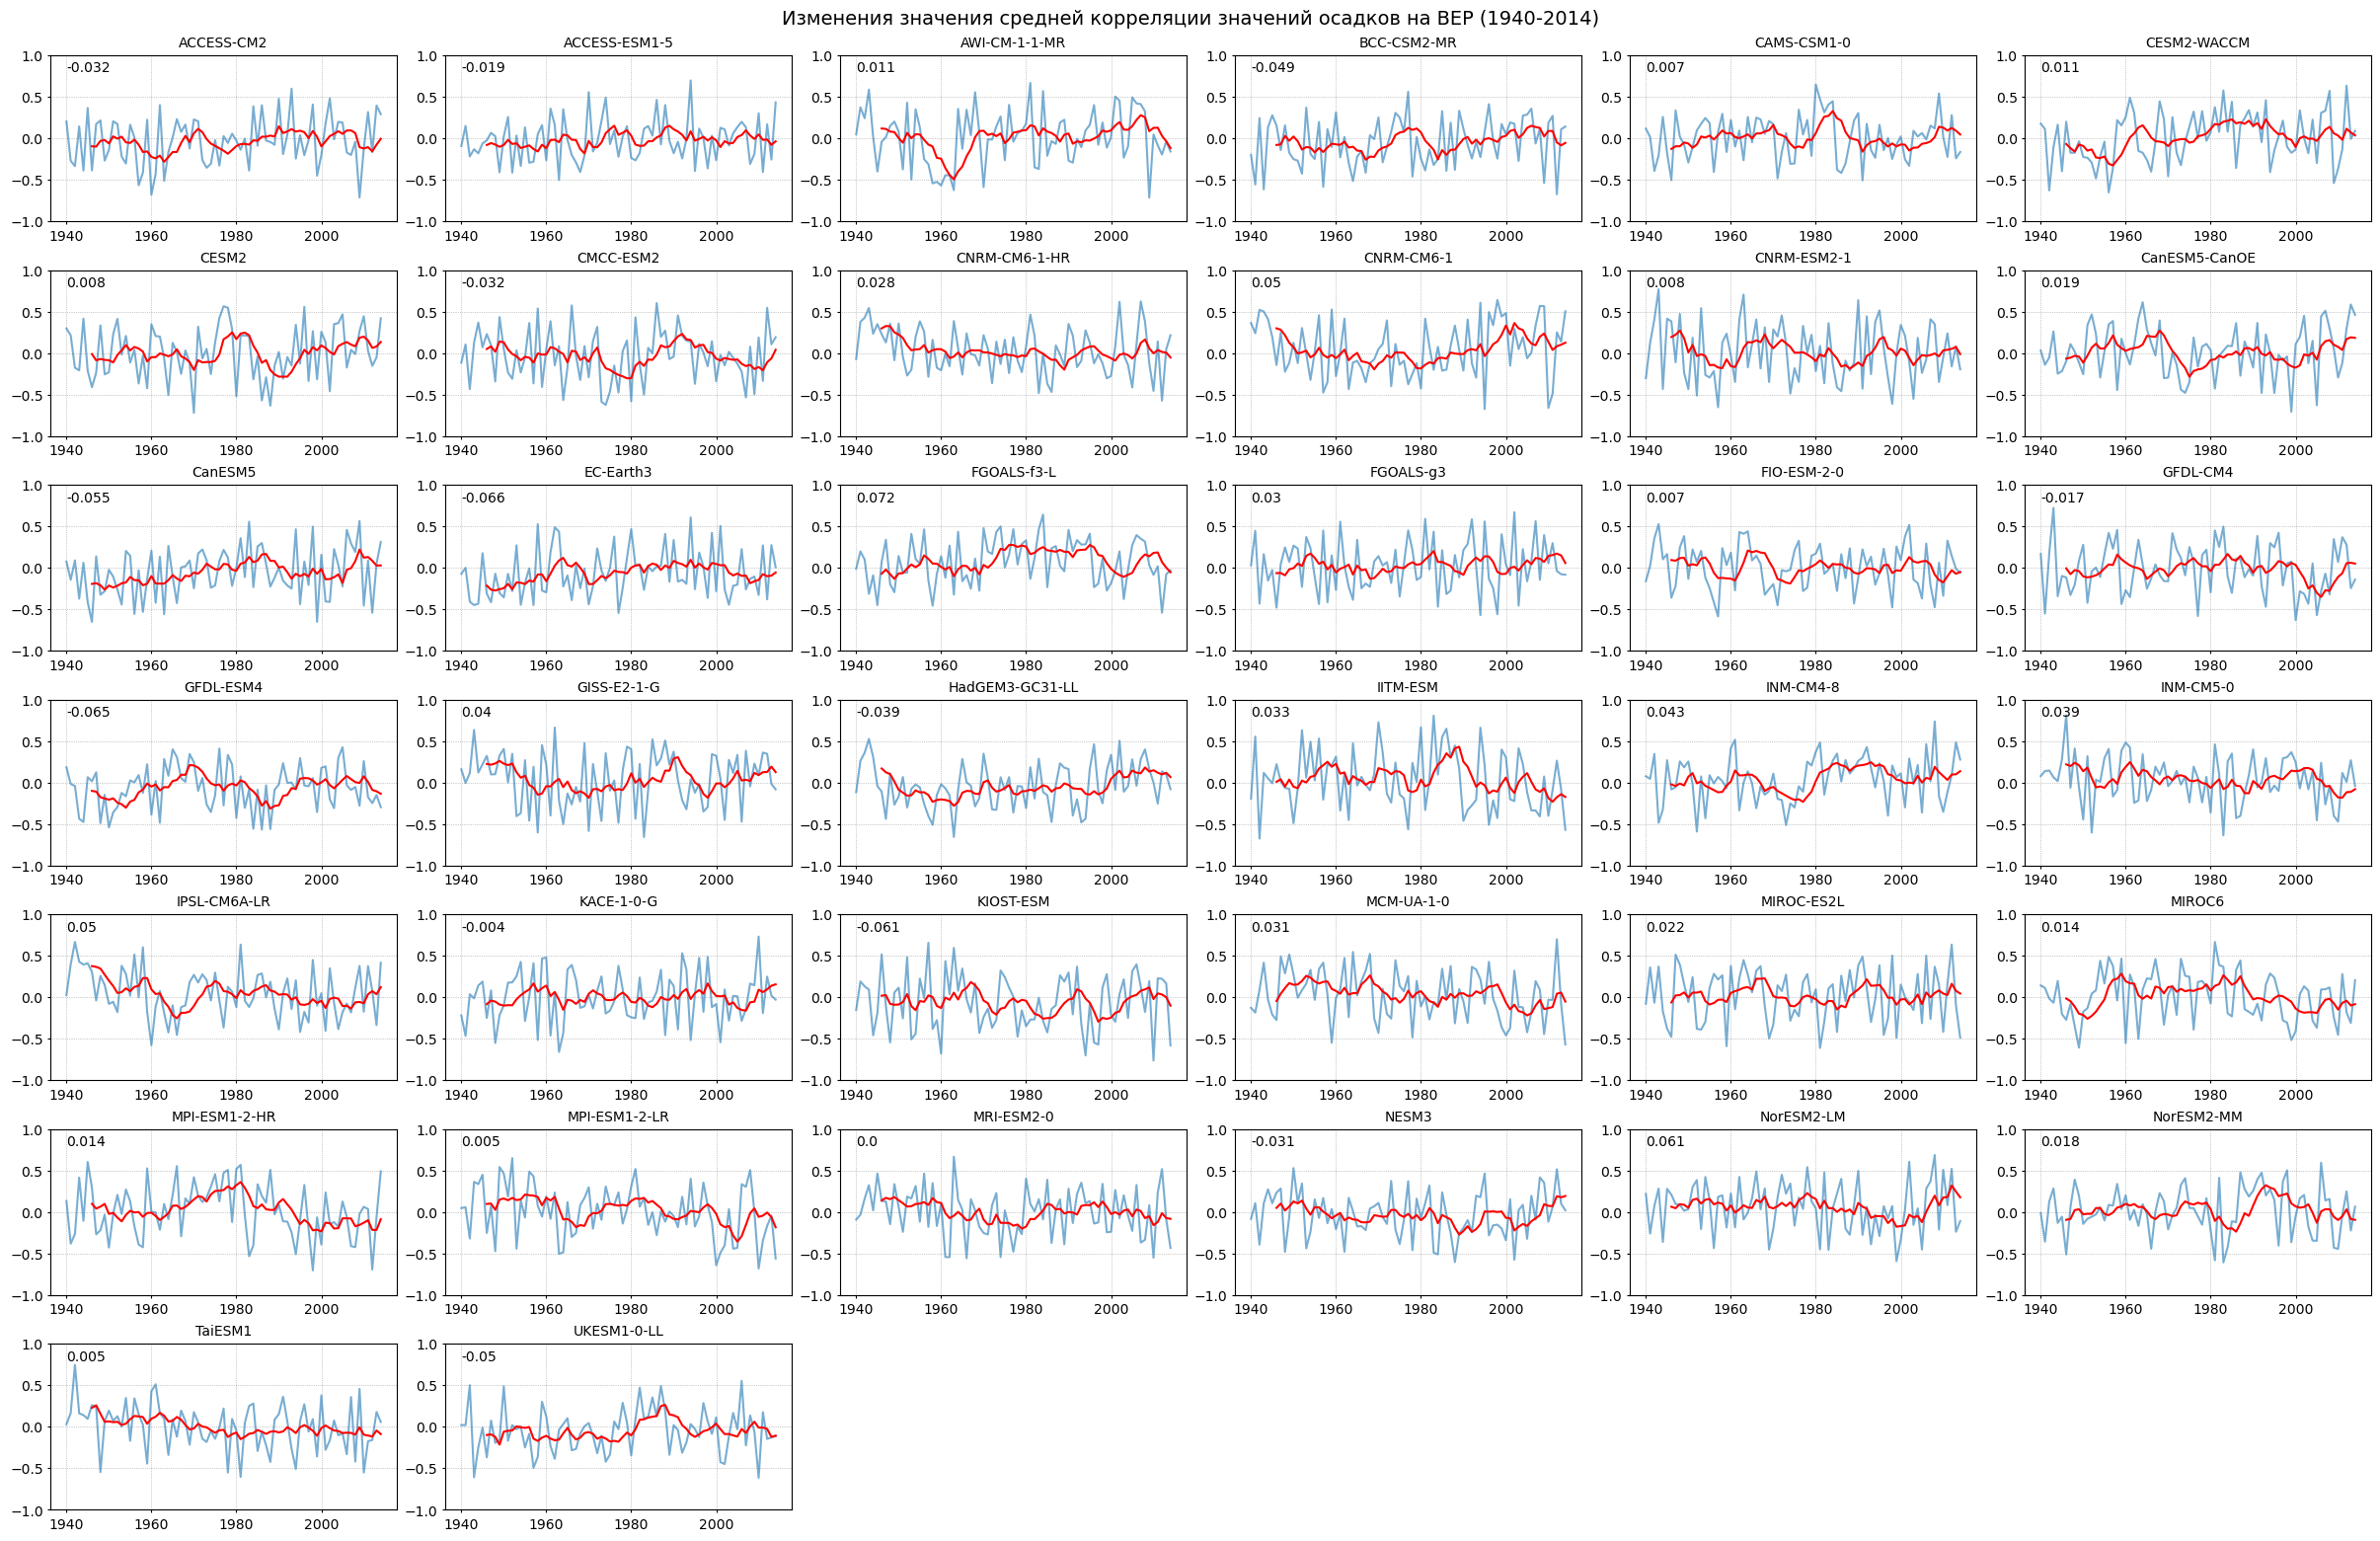

In [18]:
data_plot ('fldcor', 'timmean', file_dict, 6, 3, "Изменения значения средней корреляции значений осадков на ВЕР (1940-2014)", '', 7)

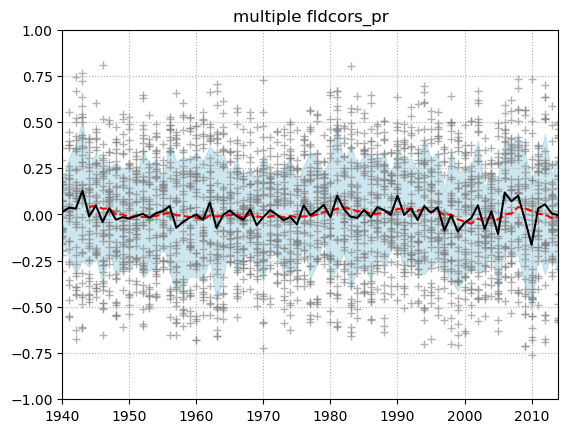

In [19]:
# Plotting many fldcors on one plot and mean for no reason
step = 5
df = df[df['bnds'] == 1]
dfs = []
for file in list(fldcor.keys()):
    df = file_dict[file].to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
    df = df[df['bnds'] == 1]
    dfs.append(df)
    plt.plot(np.arange(1940, 2015,1), df['pr'], alpha=0.6, marker='+', linestyle="", color='gray')

    roll = df.rolling(step).mean()

df_conc = pd.concat(dfs, axis=1)
roll_conc = df_conc.pr.mean(axis=1).rolling(step).mean()

plt.plot(np.arange(1940, 2015,1), roll_conc, linestyle='--', alpha=1, color='red')
plt.plot(np.arange(1940, 2015,1), df_conc.pr.mean(axis=1), linestyle='-', alpha=1, color='black')
plt.fill_between(np.arange(1940, 2015,1), df_conc.pr.mean(axis=1)+df_conc.pr.std(axis=1), df_conc.pr.mean(axis=1)-df_conc.pr.std(axis=1), color='lightblue', alpha=0.6)

plt.title("multiple fldcors_pr")
plt.grid(linestyle=':')
plt.ylim(-1,1)
plt.xlim(1940, 2014)
plt.show()
# plt.savefig("many_fldcors_t7_min.png")

## Оценка моделей: средняя корреляция

In [45]:
# Ranking models by timmean

model_df = pd.DataFrame(columns=['model', 'timmean', 'shift', 'slope'])

for i in range(1, len(list(timmean.keys()))+1):
    file = list(timmean.keys())[i-1]
    variable = list(timmean[file].variables)[-1]
    model_df.loc[i, 'model'] = file.split('_')[4]
    model_df.loc[i, 'timmean'] = float(timmean[file][variable].values[0][0][0])
model_df[model_df['timmean'] == model_df.timmean.max()]

,model,timmean,shift,slope
15,FGOALS-f3-L,0.072381,NaN,NaN


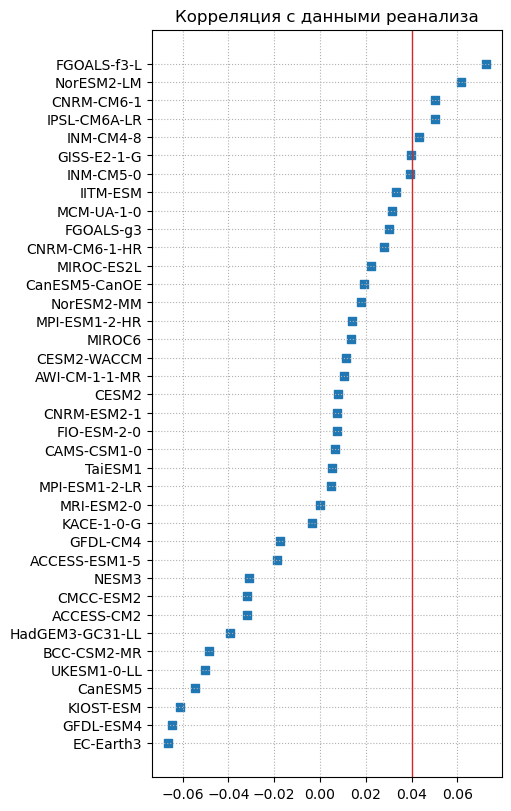

In [22]:
# Ranking models
plt.figure(figsize=(5, 8), layout='constrained')

# file = 'timmean_fldcor_tas_Amon_ACCESS-CM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc'

timmean_sorted = model_df.sort_values(by='timmean', ascending=False).reset_index()
plt.scatter(model_df.sort_values(by='timmean', ascending=True).reset_index().timmean, model_df.sort_values(by='timmean', ascending=True).reset_index()['model'],
            marker='s', c='C10')
plt.yticks(timmean_sorted['model'])
plt.grid(linestyle=':')

plt.axvline(x=0.04, color='C3', linestyle='-', lw=1.)         # <-- treshold
plt.title("Корреляция с данными реанализа")

plt.show()
# plt.savefig("precipitation_fig/mean_corr.png", dpi=300)

## Тренды

In [99]:
# Add dataframe for reanalysis
for file in list(tr_A.keys()):
    if 'ERA5' in file:
        reanalysis = file
        print(reanalysis)
        break
rean_df = pd.DataFrame({'model':['ERA5'], 'timmean':[1], 'shift':[float(tr_A[reanalysis].tp.values[0][0][0][0])], 'slope':[float(tr_B[reanalysis].tp.values[0][0][0][0])]})
rean_df

ERA5_reanalysis_1_model_grid_0_year_anom_box_ymean.nc


,model,timmean,shift,slope
0,ERA5,1,-0.241391,0.003639


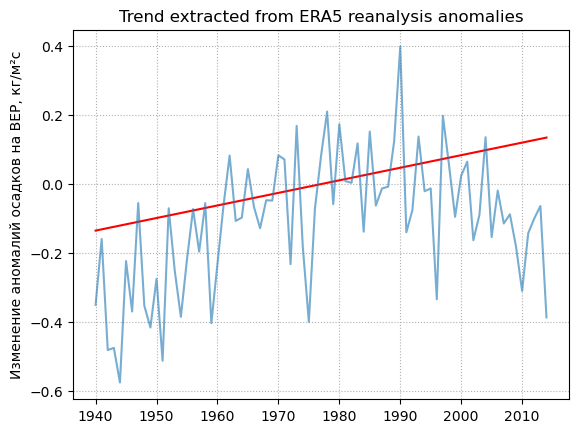

In [59]:
# Display trend in anomalies_box_yearmean in reanalysis to check that the trend matches the anomalies

fldmean_anom = pd.DataFrame(columns=['timestep', 'fldmean'])
for i in range(len(file_dict[reanalysis].time.values)):
    time0 = pd.DataFrame(file_dict[reanalysis].tp.values[i,0,:,:]).mean().mean()
    fldmean_anom.loc[i, :] = [i, time0]
a = rean_df['shift'][0]
b = rean_df['slope'][0]
x = np.linspace (1940, 2014, 75)

y = a + b*x
s = y - fldmean_anom.fldmean
y_shift = y - s.mean()

plt.plot(x, y_shift, linestyle='-', color='red')
plt.plot(x, fldmean_anom.fldmean*1000, alpha=0.6)

plt.title("Trend extracted from ERA5 reanalysis anomalies")
plt.ylabel("Изменение аномалий осадков на ВЕР, кг/м²c")
plt.grid(linestyle=':')
plt.show()

In [26]:
# Adding shift and slope values for models
trend_list = list(tr_A.keys())

for i in range(1, len(trend_list)):
    file = trend_list[i]
    variable = list(tr_A[file].variables)[-1]
    model_df['shift'][model_df['model'] == trend_list[i].split('_')[2]] = float(tr_A[file][variable].values)
    model_df['slope'][model_df['model'] == trend_list[i].split('_')[2]] = float(tr_B[file][variable].values)

C:\Users\nslob\AppData\Local\Temp\ipykernel_18176\3352787093.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model_df['shift'][model_df['model'] == trend_list[i].split('_')[2]] = float(tr_A[file][variable].values)
C:\Users\nslob\AppData\Local\Temp\ipykernel_18176\3352787093.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_inde

In [27]:
# Adding reanalysis to model_df and saving result

main_df = pd.concat((rean_df, model_df))
# main_df.to_csv('tables/precipitation.csv', index=True)

In [28]:
main_df

,model,timmean,shift,slope
0,ERA5,1,-0.241391,0.003639
1,ACCESS-CM2,-0.032016,-0.008473,0.000929
2,ACCESS-ESM1-5,-0.018671,0.058511,-0.000181
3,AWI-CM-1-1-MR,0.010598,-0.031364,0.0009
4,BCC-CSM2-MR,-0.048519,0.062404,-0.001059
5,CAMS-CSM1-0,0.006572,-0.017517,0.000329
6,CESM2-WACCM,0.011285,-0.030192,0.000697
7,CESM2,0.008016,0.007584,-0.000078
8,CMCC-ESM2,-0.0318,0.049519,-0.001044
9,CNRM-CM6-1-HR,0.027781,-0.080162,0.001955


In [29]:
treshold = 0.035
chosen_ones = model_df [ model_df.timmean >= treshold ]
chosen_ones = chosen_ones.reset_index(drop=True)
chosen_ones

,model,timmean,shift,slope
0,CNRM-CM6-1,0.050376,-0.121366,0.002422
1,FGOALS-f3-L,0.072381,0.021653,-0.000566
2,GISS-E2-1-G,0.039828,-0.066115,0.001849
3,INM-CM4-8,0.043111,0.051392,-0.000261
4,INM-CM5-0,0.039337,-0.010519,0.00042
5,IPSL-CM6A-LR,0.050335,-0.02673,0.000721
6,NorESM2-LM,0.061413,-0.004578,0.000306


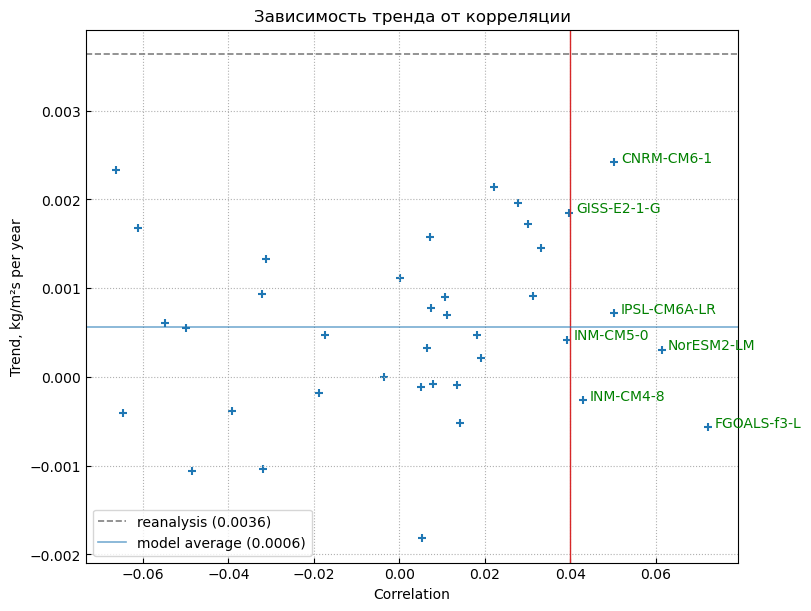

In [30]:
# Try to find connection between slope and correlation
size = model_df['shift']
plt.figure(figsize=(8,6), layout='constrained')
# print(size)
plt.scatter(model_df['timmean'], model_df['slope'], marker='+')

plt.axline(xy1=(0,rean_df['slope'][0]), xy2=(0.001,rean_df['slope'][0]), color='gray', linestyle='--', lw=1.2,
           alpha=1.0, label=f"reanalysis ({round(rean_df['slope'][0], 4)})")
plt.axline(xy1=(0.04,-0.001), xy2=(0.04,0.001), color='C3', linestyle='-', lw=1.)

# plt.axline(xy1=(model_df['timmean'].mean(), 0), xy2=(model_df['timmean'].mean(), 0.0001), alpha=0.8, c='C0', lw=1.2, ls=':')
plt.axline(xy1=(0, model_df['slope'].mean()), xy2=(0.01, model_df['slope'].mean()), alpha=0.6, c='C0', lw=1.2,
           label=f"model average ({round(model_df['slope'].mean(), 4)})")

for i, txt in enumerate(chosen_ones['slope']):
    plt.annotate(chosen_ones['model'][i], (chosen_ones['timmean'][i], chosen_ones['slope'][i]), xytext=(chosen_ones['timmean'][i]+0.0015, chosen_ones['slope'][i]),
                 color='green', fontsize=10)

plt.grid(linestyle=':')
plt.xlabel("Correlation")
plt.ylabel("Trend, kg/m²s per year")
plt.title("Зависимость тренда от корреляции")
plt.tick_params(tickdir='in')
plt.legend()

plt.show()
# plt.savefig("precipitation_fig/slope_and_corr_5.png", dpi=300)

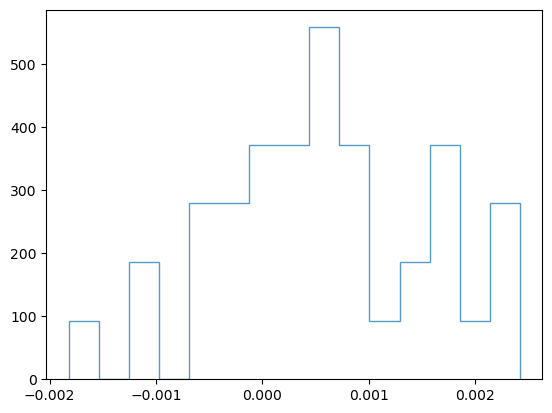

In [31]:
plt.hist(model_df.slope, 15, density=True, histtype='step', facecolor='g',
               alpha=0.75)
# plt.hist(model_df.timmean, 35, density=True, histtype='step', facecolor='g',
#                alpha=0.75)
# plt.hist2d(model_df.timmean, model_df.slope, alpha=0.6)
plt.show()

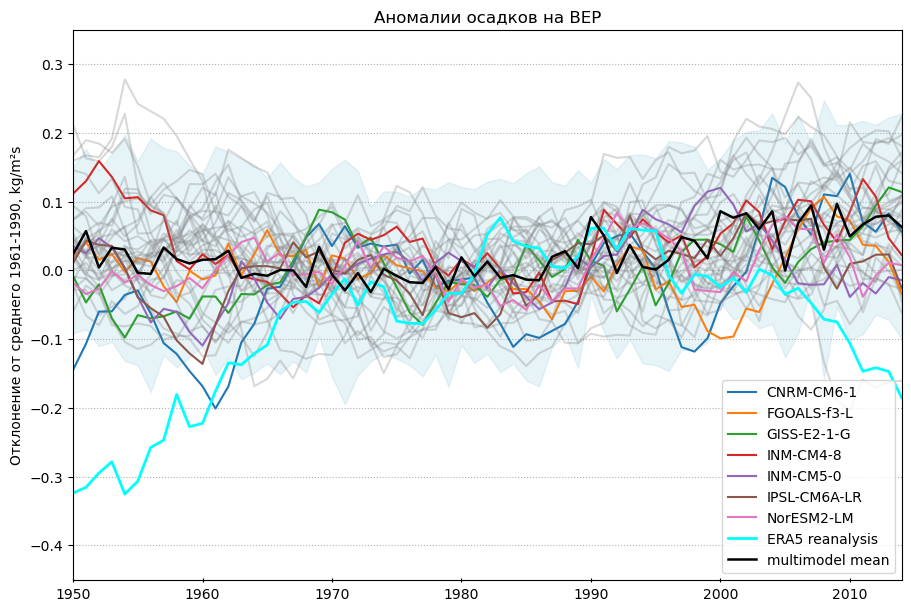

In [35]:
# Precipitation in 20th century

# fldmean_ERA5_reanalysis_1_model_grid_0_year_anom_box_ymean.nc
step = 7
df = df[df['bnds'] == 1]
dfs = []

plt.figure(figsize=(9, 6), layout='constrained')

for file in list(fldmeans.keys()):
    df = fldmeans[file].to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
    df = df[df['bnds'] == 1]
    dfs.append(df)
    if file.split('_')[3] in list(chosen_ones['model']):
        plt.plot(np.arange(1940, 2015,1), df['pr'].rolling(step).mean(), alpha=1, marker='', linestyle='-', label=file.split('_')[3])
    else:
        plt.plot(np.arange(1940, 2015,1), df['pr'].rolling(step).mean(), alpha=0.3, marker='', linestyle='-', color='gray')
    roll = df.rolling(step).mean()
df = file_dict['fldmean_ERA5_reanalysis_1_model_grid_0_year_anom_box_ymean.nc'].to_dataframe(['time', 'bnds', 'lon', 'lat', 'expver']).reset_index()
df = df[df['bnds'] == 1]
df = df*1000
plt.plot(np.arange(1940, 2015,1), df['tp'].rolling(step).mean(), c='cyan', lw=2.0, ls='-', label='ERA5 reanalysis')
df_conc = pd.concat(dfs, axis=1)
roll_conc = df_conc.pr.mean(axis=1).rolling(step).mean()

plt.plot(np.arange(1940, 2015,1), df_conc.pr.mean(axis=1), linestyle='-', alpha=1, color='black', label='multimodel mean', lw=1.8)
plt.fill_between(np.arange(1940, 2015,1), (roll_conc+df_conc.pr.std(axis=1)), (df_conc.pr.mean(axis=1)-df_conc.pr.std(axis=1)),
                 color='lightblue', alpha=0.3, label='')

plt.title("Аномалии осадков на ВЕР")
plt.ylabel("Отклонение от среднего 1961-1990, kg/m²s")
plt.legend(loc='lower right')

plt.grid(linestyle=':', axis='y')
plt.ylim(-0.45,0.35)
plt.xlim(1950, 2014)
plt.tick_params('x', tickdir='inout')
plt.show()
# plt.savefig("precipitation_fig/precipitation_anom_7.png", dpi=300)

In [37]:
file_dict['pr_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc'].attrs
# fldmeans[list(fldmeans.keys())[0]].attrs

{'Conventions': 'CF-1.7 CMIP-6.2',
 'activity_id': 'CMIP',
 'branch_method': 'standard',
 'branch_time_in_child': 0.0,
 'branch_time_in_parent': 0.0,
 'creation_date': '2019-11-08T08:26:37Z',
 'data_specs_version': '01.00.30',
 'experiment': 'all-forcing simulation of the recent past',
 'experiment_id': 'historical',
 'external_variables': 'areacella',
 'forcing_index': 1,
 'frequency': 'mon',
 'further_info_url': 'https://furtherinfo.es-doc.org/CMIP6.CSIRO-ARCCSS.ACCESS-CM2.historical.none.r1i1p1f1',
 'grid': 'native atmosphere N96 grid (144x192 latxlon)',
 'grid_label': 'gn',
 'history': '2019-11-08T08:26:37Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.',
 'initialization_index': 1,
 'institution': 'CSIRO (Commonwealth Scientific and Industrial Research Organisation, Aspendale, Victoria 3195, Australia), ARCCSS (Australian Research Council Centre of Excellence for Climate System Science)',
 'institution_id': 'CSIRO-ARCCSS',
 'mip_era': 'CMIP6',
 